In [81]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from datetime import datetime, timedelta
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from numpy.linalg import inv
register_matplotlib_converters()
sns.set_context('notebook')

# Fetch the data 
mauna_lao = fetch_openml('mauna-loa-atmospheric-co2')
print(mauna_lao.DESCR)
data = mauna_lao.data
# Assemble the day/time from the data columns so we can plot it
d1958 = datetime(year=1958,month=1,day=1)
time = [datetime(int(d[0]),int(d[1]),int(d[2])) for d in data] 
X = np.array([1958+(t-d1958)/timedelta(days=365.2425) for t in time]).T
X = X.reshape(-1,1)  # Make it a column to make scikit happy
y = np.array(mauna_lao.target)

**Weekly carbon-dioxide concentration averages derived from continuous air samples for the Mauna Loa Observatory, Hawaii, U.S.A.**<br><br>
These weekly averages are ultimately based on measurements of 4 air samples per hour taken atop intake lines on several towers during steady periods of CO2 concentration of not less than 6 hours per day; if no such periods are available on a given day, then no data are used for that day. The _Weight_ column gives the number of days used in each weekly average. _Flag_ codes are explained in the NDP writeup, available electronically from the [home page](http://cdiac.ess-dive.lbl.gov/ftp/trends/co2/sio-keel-flask/maunaloa_c.dat) of this data set. CO2 concentrations are in terms of the 1999 calibration scale (Keeling et al., 2002) available electronically from the references in the NDP writeup which can be accessed from the home page of this data set.
<br><br>
### Feature Descriptions
_co2_: average co2 concentration in ppvm <br>
_year_: year of concent

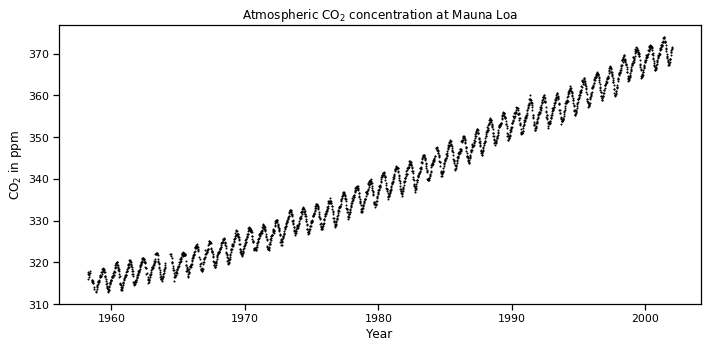

In [82]:
# Plot the data
plt.figure(figsize=(10,5))    # Initialize empty figure
plt.scatter(X, y, c='k',s=1) # Scatterplot of data
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()

## Pick KRR as regression model

## Use Grid Search to choose kernel sets


In [83]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel 
from sklearn.gaussian_process.kernels import Matern, RBF, RationalQuadratic
from sklearn.gaussian_process.kernels import Sum, Product, Exponentiation
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct

from sklearn.model_selection import GridSearchCV
import time

In [84]:
param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3, 1e-4],
              "kernel": [ RBF(length_scale=10.0),
                          RBF(length_scale=1.0),
                          ExpSineSquared(periodicity = 1.0),
                          ExpSineSquared(periodicity = 1.5),
                          2500* RBF(length_scale = 60),
                          5 * RBF(length_scale=90.0) \
                          * ExpSineSquared(length_scale=1, periodicity=1),
                          0.5**2 \
                          * RationalQuadratic(length_scale=1, alpha=1),
                          0.15 * RBF(length_scale=0.1) \
                          + WhiteKernel(noise_level=0.4),
                          RBF(length_scale=1000)+ExpSineSquared(length_scale=1, periodicity=1)+WhiteKernel(noise_level=10)]}

kr = GridSearchCV(KernelRidge(), cv=5, param_grid=param_grid)

In [85]:
kr.fit(X_data, y_data)

GridSearchCV(cv=5, error_score=nan,
             estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                   kernel='linear', kernel_params=None),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1.0, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': [RBF(length_scale=10), RBF(length_scale=1),
                                    ExpSineSquared(length_scale=1, periodicity=1),
                                    ExpSineSquared(length_scale=1, periodicity=1.5),
                                    50...
                                    2.24**2 * RBF(length_scale=90) * ExpSineSquared(length_scale=1, periodicity=1),
                                    0.5**2 * RationalQuadratic(alpha=1, length_scale=1),
                                    0.387**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.4),
                                    RBF(length_scale=1e+03) + ExpSineSquared(length_scale=1, periodicity=1) + 

In [86]:
kr.best_score_, kr.best_params_

(0.9489676666764449,
 {'alpha': 0.0001,
  'kernel': 2.24**2 * RBF(length_scale=90) * ExpSineSquared(length_scale=1, periodicity=1)})

In [87]:
# Helper code to perform the plotting for you
# You don't need to modify this cell
from textwrap import wrap
def plot_CO2_data(model,X,y,extrapolate=0,plot_var=False):
    # krr is a Kernel Ridge Regression object
    model.fit(X,y)
    
    model.fit(X, y)

    # Predict using kernel ridge
    X_plot = np.linspace(X.min(), X.max()+extrapolate, 10000)[:, None]
    y_p = model.predict(X_plot)
    
    # Plotting
    plt.figure(figsize=(10,5))
    # Plot Original Data
    plt.scatter(X, y, s=10, marker='o', linewidths=1,
            edgecolors='k', facecolors='none',
           label='Data')
    plt.plot(X_plot,y_p,alpha=1,lw=2,label='Prediction')
    title_str = "\n".join(wrap(str(model.kernel), 60))
    title_str+='\n'+"$R^2$: {:.3f}".format(model.score(X,y))
    plt.title("Kernel: "+str(title_str))
    plt.xlabel("Year")
    plt.ylabel("$CO^2$")
    #plt.tight_layout()
    plt.legend()
    plt.show()

## Final kernel

In [88]:
kernels_to_plot = [2.24**2 * RBF(length_scale=90) * ExpSineSquared(length_scale=1, periodicity=1)]

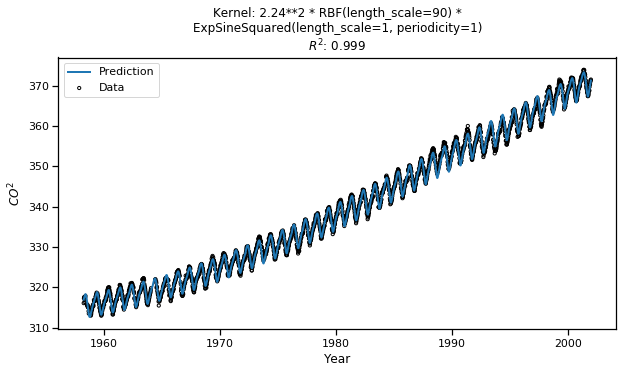

In [89]:
for kernel in kernels_to_plot:
    kr = KernelRidge(alpha = 0.0001,
                     kernel= kernel) 
    # Now extrapolate 30 years into the future and past:
    plot_CO2_data(kr,X,y,extrapolate=0)

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
d=1
i=1

N=[50,100,200,500,1000,2000]

for n in N: 
    X_train=X[0:n]
    y_train=y[0:n]
    X_test=X[n:]
    X_test=y[n:]
    
    plt.figure(figsize=(7, 7)) # Make a new figure
    # Construct the polynomial features
  
    # Construct linear regression model
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    # Now fit the data first through the 
    # polynomial basis, then do regression
    pipeline.fit(X_train, y_train)
    
    # Get the accuracy score of the trained model
    # on the original training data
    score = pipeline.score(X_train, y_train)
    # Plot the results
    #X_plot = np.linspace(0, 1, 100)
    plt.subplot(3,2,i)
    plt.plot(X, pipeline.predict(X), label="Model")
    #plt.plot(X_plot, true_fun(X_plot), '--',label="True function")
    plt.scatter(X, y, label="Samples",c='k',s=1)
    plt.xlabel("x")
    plt.ylabel("y")
    #plt.xlim((0, 1))
    #plt.ylim((-2, 2))
    #plt.legend(loc="best")
    plt.title("Degree {}\nTrain score = {:.3f}\nTrain_num {}".format(
        d, score,n))
    plt.show()  
    i=i+1

NameError: name 'polynomial_features' is not defined

<Figure size 504x504 with 0 Axes>